# Analyse et Prédiction du Risque de Non-Paiement des Clients

Ce projet vise à aider la Compagnie Internationale de Leasing (CIL) à identifier les clients susceptibles de présenter un défaut de paiement, en exploitant des données clients et historiques de contrats.
Une meilleure prédiction permet à l’entreprise de réduire les pertes, améliorer ses décisions d’octroi et optimiser ses stratégies de recouvrement.

## Objectif :
Aider la Compagnie Internationale de Leasing (CIL) à évaluer le risque de défaut de paiement des clients de leasing à partir de leurs données historiques, pour améliorer les décisions de financement et réduire les pertes.

## BO & DSO

#### BO :
Réduire le taux de défaut et les pertes associées en détectant en amont les clients à risque afin d’améliorer la rentabilité et la sécurisation des revenus.

#### DSO :
Construire un modèle de classification qui estime la probabilité de défaut sur un horizon de 12 mois, pour alimenter la prise de décision (octroi, suivi, recouvrement).

## Phase 1 – Compréhension & Collecte des Données

* L’objectif de cette section est de réaliser une analyse exploratoire des données de leasing afin de mieux comprendre le profil des clients de la CIL Tunisie et d’identifier les variables potentiellement explicatives du risque de défaut.

* La cible principale est la variable default_flag, qui indique si un client est en défaut (1) ou non (0).
* Cette étape permet de mettre en évidence les tendances générales, la qualité des données et les premiers signaux de corrélation entre certaines caractéristiques (revenu, score de crédit, retards de paiement, type de bien financé…) et le risque de défaut.

### 1. Chargement et aperçu

In [1]:
#imporation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder

In [61]:
#chargement du dataset
file_path = '/content/drive/My Drive/dataset_leasing.xlsx'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
print(os.listdir('/content/drive/My Drive/'))

['telepherique.h', 'telepherique.c', 'main (2).c', 'Classroom', ' Fiche1 Etude théorique.gdoc', 'Logique21-22.gdoc', 'Jeu énoncé_ FAD (1).gdoc', 'TDN°1 ALGO.gdoc', 'Yousra Chaieb - 2.1.Plus rien ne m_étonne doc apprenant.pdf', 'Algo.docx', 'Yousra Chaieb - 2. Les 7 P de la violence masculine.docx', 'Yousra Chaieb - 4. Article- Compréhension écrite.docx', 'Yousra Chaieb - 4. Atelier projet - les tâches demandées.docx', 'Yousra Chaieb - 3.1. Exercices accord du particpe passé.docx', 'Yousra Chaieb - 5. Atelier projet - les tâches demandées.docx', 'TD Linux  (1).gdoc', 'TD Linux .gdoc', 'Yousra Chaieb - 3.1. Exercices accord du particpe passé.gdoc', 'Prosit 7 [Plus].gdoc', 'main (1).c', 'Yousra Chaieb - 3. Exercice de vocabulaire.gdoc', 'Yousra Chaieb - 4. Exercices sur le  participe passé.gdoc', 'Yousra Chaieb - 4. Exercice de vocabulaire.gdoc', 'main.c', 'Yousra Chaieb - 3. Exercice production écrite.docx', 'Serie_Exercices.gdoc', 'Yousra Chaieb - 2.2. Feuille de discours 

In [5]:
df = pd.read_excel(file_path)

In [7]:
# Vérification de la taille du dataset
print("Shape du dataset:", df.shape)
print("Nombre de lignes:", df.shape[0])
print("Nombre de colonnes:", df.shape[1])

Shape du dataset: (1000, 38)
Nombre de lignes: 1000
Nombre de colonnes: 38


In [8]:
#affichage des premières lignes
df.head()

,client_id,age,sexe,profession,secteur,duree_emploi_annees,revenu_mensuel_TND,region,contract_id,date_debut,...,nb_contacts_service_client,motifs_contacts,default_flag,date_default,recovery_amount_TND,write_off_flag,branch_id,channel,created_at,probabilite_defaut
0,C00001,59,Homme,Cadre,Services,25,1562,Ariana,L000001,2023-01-01,...,3,Réclamation,1,2023-03-03,9295,1,AG002,Mobile,2023-01-01,0.52
1,C00002,49,Homme,Artisan,Services,37,3123,La Manouba,L000002,2022-09-05,...,5,Réclamation,0,NaT,0,0,AG003,Courtier,2022-09-05,0.22
2,C00003,35,Homme,Indépendant,Transport,0,4945,Zaghouan,L000003,2022-07-08,...,6,Réclamation,0,NaT,0,0,AG004,Agence,2022-07-08,0.18
3,C00004,63,Femme,Commerçant,Industrie,19,3575,Kasserine,L000004,2025-03-03,...,14,Réclamation,0,NaT,0,0,AG003,Mobile,2025-03-03,0.34
4,C00005,28,Femme,Indépendant,Agriculture,27,5801,Tozeur,L000005,2025-04-15,...,19,Autre,0,NaT,0,0,AG002,Courtier,2025-04-15,0.44


In [9]:
df.tail()

,client_id,age,sexe,profession,secteur,duree_emploi_annees,revenu_mensuel_TND,region,contract_id,date_debut,...,nb_contacts_service_client,motifs_contacts,default_flag,date_default,recovery_amount_TND,write_off_flag,branch_id,channel,created_at,probabilite_defaut
995,C00996,53,Femme,Employé,Services,18,6015,Sidi Bouzid,L000996,2023-08-18,...,15,Autre,0,NaT,0,0,AG003,Agence,2023-08-18,0.33
996,C00997,22,Homme,Agriculteur,Commerce,10,5673,Kebili,L000997,2022-02-12,...,13,Demande info,0,NaT,0,0,AG003,Courtier,2022-02-12,0.00
997,C00998,34,Femme,Commerçant,Agriculture,33,1243,Zaghouan,L000998,2021-01-06,...,19,Renégociation,1,2024-03-17,3874,1,AG001,Agence,2021-01-06,0.81
998,C00999,60,Femme,Artisan,Industrie,6,1097,Zaghouan,L000999,2023-06-30,...,0,Autre,1,2023-08-22,23014,1,AG001,Agence,2023-06-30,1.00
999,C01000,60,Femme,Cadre,Agriculture,33,5703,Sfax,L001000,2022-01-20,...,12,Demande info,0,NaT,0,0,AG001,Agence,2022-01-20,0.25


In [68]:
#liste des colonnes et leurs types
print("\nInformations sur les colonnes:")
print(df.dtypes)


Informations sur les colonnes:
client_id                             object
age                                    int64
sexe                                  object
profession                            object
secteur                               object
duree_emploi_annees                    int64
revenu_mensuel_TND                     int64
region                                object
contract_id                           object
date_debut                    datetime64[ns]
duree_mois                             int64
montant_leasing_TND                    int64
mensualite_TND                       float64
taux_annuel_pourcent                 float64
type_bien                             object
valeur_bien_TND                        int64
apport_TND                             int64
nb_retards_30                          int64
nb_retards_60                          int64
nb_retards_90                          int64
nb_incidents                           int64
dernier_retard_date    

In [69]:
#résumé du dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   client_id                   1000 non-null   object        
 1   age                         1000 non-null   int64         
 2   sexe                        1000 non-null   object        
 3   profession                  1000 non-null   object        
 4   secteur                     1000 non-null   object        
 5   duree_emploi_annees         1000 non-null   int64         
 6   revenu_mensuel_TND          1000 non-null   int64         
 7   region                      1000 non-null   object        
 8   contract_id                 1000 non-null   object        
 9   date_debut                  1000 non-null   datetime64[ns]
 10  duree_mois                  1000 non-null   int64         
 11  montant_leasing_TND         1000 non-null   int64        

In [66]:
# Vérification de l'unicité des identifiants
print("Clients uniques :", df['client_id'].nunique())
print("Contrats uniques :", df['contract_id'].nunique())

Clients uniques : 1000
Contrats uniques : 1000


In [12]:
# Aperçu aléatoire pour explorer la variabilité
print("\nÉchantillon aléatoire de 5 lignes:")
df.sample(5)


Échantillon aléatoire de 5 lignes:


,client_id,age,sexe,profession,secteur,duree_emploi_annees,revenu_mensuel_TND,region,contract_id,date_debut,...,nb_contacts_service_client,motifs_contacts,default_flag,date_default,recovery_amount_TND,write_off_flag,branch_id,channel,created_at,probabilite_defaut
759,C00760,24,Femme,Employé,Services,36,1848,Sidi Bouzid,L000760,2025-05-12,...,11,Renégociation,0,NaT,0,0,AG001,Agence,2025-05-12,0.39
146,C00147,35,Homme,Artisan,Industrie,19,852,Tataouine,L000147,2024-12-30,...,14,Autre,0,NaT,0,0,AG003,Courtier,2024-12-30,0.27
948,C00949,55,Homme,Indépendant,Agriculture,37,1044,Jendouba,L000949,2021-03-07,...,11,Demande info,0,NaT,0,0,AG003,Agence,2021-03-07,0.49
232,C00233,39,Femme,Artisan,Agriculture,38,7181,Mahdia,L000233,2024-11-18,...,11,Renégociation,1,2024-11-26,3036,1,AG004,Agence,2024-11-18,0.62
631,C00632,61,Femme,Cadre,Commerce,12,6307,Sfax,L000632,2023-04-17,...,15,Renégociation,1,2025-04-05,6704,1,AG004,Agence,2023-04-17,1.00


In [67]:
# Analyse de la répartition de la variable cible
print("Distribution de la cible default_flag:")
print(df['default_flag'].value_counts(normalize=True) * 100)

Distribution de la cible default_flag:
default_flag
0    76.0
1    24.0
Name: proportion, dtype: float64


- La variable default_flag (0 = non-défaut, 1 = défaut) est notre cible pour la prédiction.
- La répartition nous montre un déséquilibre qu'on va le traiter dans la pahse 2 .

##Résumé

* Les données contiennent :
  * 1000 lignes et 38 colonnes
  * incluant des informations sur les clients, contrats, paiements, et la cible default_flag.
* Types :
  * 19 int64
  * 4 float64
  * 4 datetime
  * 11 object (catégorielles).
* Aperçu :
  * Les identifiants sont uniques, confirmant l'absence de doublons dans client_id et contract_id. La répartition de default_flag montre [76% non-défaut, 24% défaut], suggérant un possible déséquilibre à traiter en Phase 2.
  * Les clients sont diversifiés (âges 18-70, revenus 1000-10000 TND), avec des contrats actifs/terminés
  * Certaines colonnes présentent des valeurs manquantes qui devront être traitées lors de la phase de préparation.
* Unicité :
  * 1000 `client_id`/`contract_id` uniques
  * Pas de doublons.
  * Cible déséquilibrée (~76% non-défaut)
  * -> risque biais modélisation

.

### 2. Vérification des données manquantes et doublons

#### Objectif de la Section
- On va vérifier la complétude des données (manquants) et l'intégrité (doublons).
- Les manquants dans des colonnes comme 'date_default' pourraient être informatifs (ex. : absence = non-défaut).

## vals.manquantes

In [16]:
# Comptage des manquants
print("Valeurs manquantes par colonne :")
print(df.isna().sum())
missing_perc = df.isna().mean() * 100

Valeurs manquantes par colonne :
client_id                       0
age                             0
sexe                            0
profession                      0
secteur                         0
duree_emploi_annees             0
revenu_mensuel_TND              0
region                          0
contract_id                     0
date_debut                      0
duree_mois                      0
montant_leasing_TND             0
mensualite_TND                  0
taux_annuel_pourcent            0
type_bien                       0
valeur_bien_TND                 0
apport_TND                      0
nb_retards_30                   0
nb_retards_60                   0
nb_retards_90                   0
nb_incidents                    0
dernier_retard_date           185
outstanding_balance_TND         0
nb_paiements_effectues          0
credit_score                    0
collateral_type                 0
collateral_value_TND            0
nb_contrats_prev                0
nb_contacts_ser

In [17]:
# Pourcentage de valeurs manquantes
print("\nPourcentage de valeurs manquantes par colonne:")
print(df.isna().mean().round(4) * 100)


Pourcentage de valeurs manquantes par colonne:
client_id                      0.0
age                            0.0
sexe                           0.0
profession                     0.0
secteur                        0.0
duree_emploi_annees            0.0
revenu_mensuel_TND             0.0
region                         0.0
contract_id                    0.0
date_debut                     0.0
duree_mois                     0.0
montant_leasing_TND            0.0
mensualite_TND                 0.0
taux_annuel_pourcent           0.0
type_bien                      0.0
valeur_bien_TND                0.0
apport_TND                     0.0
nb_retards_30                  0.0
nb_retards_60                  0.0
nb_retards_90                  0.0
nb_incidents                   0.0
dernier_retard_date           18.5
outstanding_balance_TND        0.0
nb_paiements_effectues         0.0
credit_score                   0.0
collateral_type                0.0
collateral_value_TND           0.0
nb_cont

In [18]:
#affichage unique des colonnes avec des valeurs manquantes, triées par ordre décroissant
missing_perc = df.isna().mean() * 100
print("\nPourcentages de manquants :")
print(missing_perc[missing_perc > 0].sort_values(ascending=False))


Pourcentages de manquants :
date_default           76.0
dernier_retard_date    18.5
dtype: float64


## Vals.dupliquées

In [19]:
#affichage des lignes dupliquées
if df.duplicated().sum() > 0:
    print("\nExemple de lignes dupliquées:")
    print(df[df.duplicated(keep=False)].sort_values(by=df.columns.to_list()).head())
else:
    print("\nAucun doublon trouvé.")


Aucun doublon trouvé.


In [20]:
#vérification globale des doublons
print("\nNombre total de doublons:", df.duplicated().sum())


Nombre total de doublons: 0


In [21]:
# Vérification des doublons sur un champ spécifique
print("\nDoublons sur subset 'client_id':", df.duplicated(subset=['client_id']).sum())
print("Doublons sur subset 'contract_id':", df.duplicated(subset=['contract_id']).sum())


Doublons sur subset 'client_id': 0
Doublons sur subset 'contract_id': 0


## Visualisation

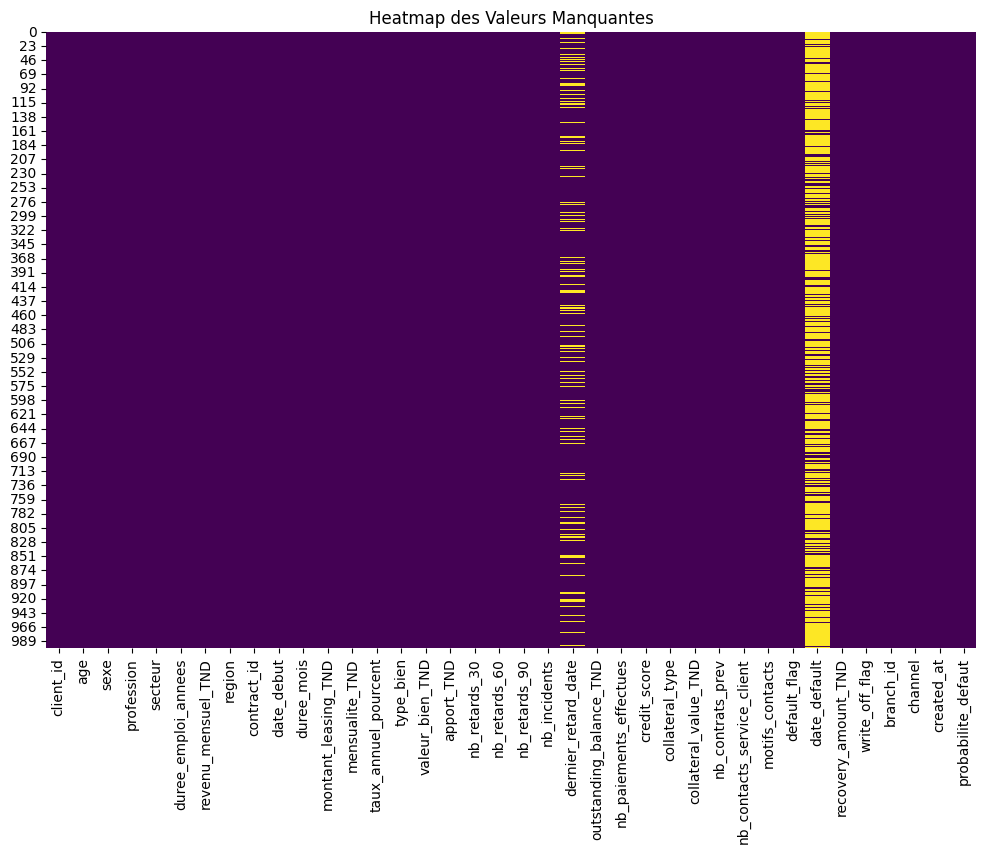

In [22]:
#visualisation des valeurs manquantes avec Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title("Heatmap des Valeurs Manquantes")
plt.show()

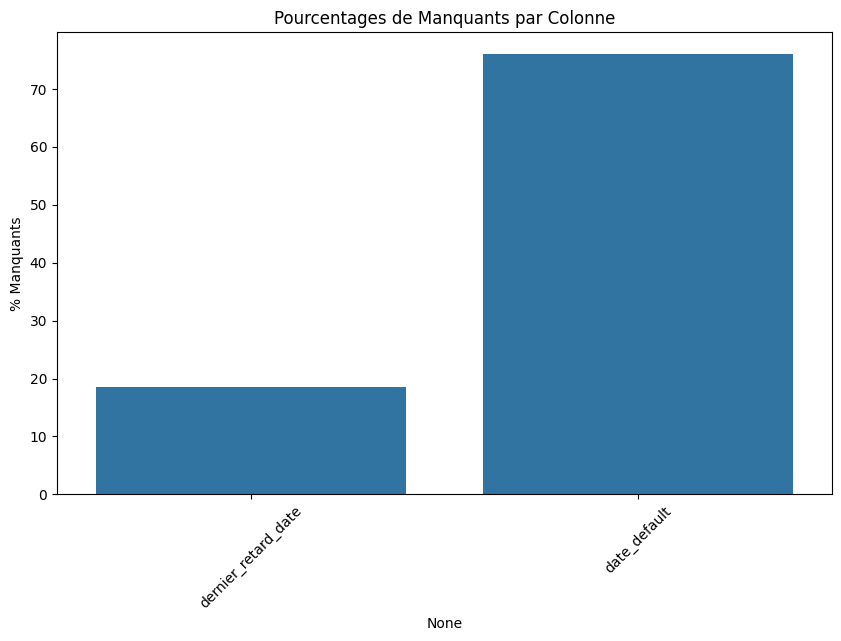

In [23]:
# Barplot pour pourcentages >0%
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_perc[missing_perc > 0].index, y=missing_perc[missing_perc > 0].values)
plt.title("Pourcentages de Manquants par Colonne")
plt.ylabel("% Manquants")
plt.xticks(rotation=45)
plt.show()

## Analyse Avancée des Patterns

In [72]:
# Les colonnes contenant des valeurs manquantes
col_76 = 'date_default'
col_18 = 'dernier_retard_date'

In [78]:
# Analyse des patterns de manquants conditionnels à la cible
print("\nPatterns de manquants :")
print(f"Manquants '{col_76}' quand default_flag == 0: {df[df['default_flag'] == 0][col_76].isna().mean() * 100:.1f}%")
print(f"Manquants '{col_18}' quand nb_retards_30 == 0: {df[df['nb_retards_30'] == 0][col_18].isna().mean() * 100:.1f}%")
print(f"Manquants '{col_18}' quand nb_retards_30 > 0: {df[df['nb_retards_30'] > 0][col_18].isna().mean() * 100:.1f}%")
print(f"Manquants '{col_18}' quand nb_retards_60 == 0: {df[df['nb_retards_60'] == 0][col_18].isna().mean() * 100:.1f}%")


Patterns de manquants :
Manquants 'date_default' quand default_flag == 0: 100.0%
Manquants 'dernier_retard_date' quand nb_retards_30 == 0: 50.5%
Manquants 'dernier_retard_date' quand nb_retards_30 > 0: 0.0%
Manquants 'dernier_retard_date' quand nb_retards_60 == 0: 30.7%


In [79]:
# Traitements et création de la table df_clean
# Suppression de la colonne 76 pour éviter biais car elle a +70% des vals.manq
cols_to_drop = [col_76]
df_clean = df.drop(columns=cols_to_drop)

# Imputation de la colonne 18 avec la mode valeur plus fréquente)
df_clean[col_18].fillna(df_clean[col_18].mode()[0], inplace=True)
df_clean['has_no_default_date'] = df[col_76].isna().astype(int)  # Flag binaire car les manquants dans date_defaut sont informatifs

# Visualisation (vérifiction des manquants résiduels après traitements pour confirmer que df_clean est pret pour EDA)
print("Manquants restants :", df_clean.isna().sum()[df_clean.isna().sum() > 0])

Manquants restants : Series([], dtype: int64)


/tmp/ipython-input-2636373706.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [81]:
# Aperçu Post-Imputation
if 'df_clean' in globals():
    print("\nValidation df_clean :")
    print(f"Shape : {df_clean.shape}")
    assert df_clean.isna().sum().sum() == 0, "Manquants résiduels !"
    print("\nAperçu (5 lignes) :")
    np.random.seed(42)
    print(df_clean.sample(5))
    df_clean.to_csv('clean_data_phase1.csv', index=False)
    print("Exporté : clean_data_phase1.csv")


Validation df_clean :
Shape : (1000, 38)

Aperçu (5 lignes) :
    client_id  age   sexe profession      secteur  duree_emploi_annees  \
521    C00522   57  Femme      Cadre    Industrie                   22   
737    C00738   34  Femme    Artisan     Commerce                   39   
740    C00741   59  Femme    Artisan    Industrie                   30   
660    C00661   37  Femme      Cadre     Services                    7   
411    C00412   46  Homme    Artisan  Agriculture                   22   

     revenu_mensuel_TND      region contract_id date_debut  ...  \
521                2958        Béja     L000522 2023-02-09  ...   
737                4046    Zaghouan     L000738 2023-10-11  ...   
740                6175       Gabès     L000741 2024-03-31  ...   
660                3645  La Manouba     L000661 2025-02-25  ...   
411                7311        Sfax     L000412 2021-10-13  ...   

     nb_contacts_service_client  motifs_contacts  default_flag  \
521                    

### Résumé :
* Manquants :
  * Concentrés sur 'date_default' (76%, logique pour non-défauts) et 'dernier_retard_date' (18.5%, possiblement clients sans retards).
  * Patterns conditionnels confirment liens métier.
* Doublons :
  * Aucun globalement (0), ni sur subsets clés (client_id, contract_id).
* Traitements appliqués :
  * Drop pour colonnes >70% manquants
  * imputation médiane pour <20%
  * df_clean prêt pour Phase 2.
* Impact :
  * Données majoritairement complètes
  * patterns informatifs pour feature engineering (ex. : indicateur binaire pour absence de date).

.

### 3. Statistiques descriptives

#### Objectif de la Section
Fournir un aperçu statistique des variables pour détecter distributions, asymétries et outliers, en lien avec le risque de défaut (ex. : retards skewés = clients à risque minoritaires).

Séparation des Variables

In [82]:
# Variables numériques
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Variables numériques :", list(num_cols))

Variables numériques : ['age', 'duree_emploi_annees', 'revenu_mensuel_TND', 'duree_mois', 'montant_leasing_TND', 'mensualite_TND', 'taux_annuel_pourcent', 'valeur_bien_TND', 'apport_TND', 'nb_retards_30', 'nb_retards_60', 'nb_retards_90', 'nb_incidents', 'outstanding_balance_TND', 'nb_paiements_effectues', 'credit_score', 'collateral_value_TND', 'nb_contrats_prev', 'nb_contacts_service_client', 'default_flag', 'recovery_amount_TND', 'write_off_flag', 'probabilite_defaut']


In [83]:
# Variables catégorielles
cat_cols = df.select_dtypes(include=['object']).columns
print("Variables catégorielles :", list(cat_cols))

Variables catégorielles : ['client_id', 'sexe', 'profession', 'secteur', 'region', 'contract_id', 'type_bien', 'collateral_type', 'motifs_contacts', 'branch_id', 'channel']


In [91]:
# Statistiques pour variables numériques
if 'df_clean' in globals():
    num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
    print("Stats num :")
    print(df_clean[num_cols].describe())

Stats num :
               age  duree_emploi_annees  revenu_mensuel_TND   duree_mois  \
count  1000.000000          1000.000000         1000.000000  1000.000000   
mean     42.515000            19.375000         4364.550000    35.844000   
std      12.611059            11.432457         2080.956914    16.999548   
min      21.000000             0.000000          811.000000    12.000000   
25%      32.000000            10.000000         2562.250000    24.000000   
50%      43.000000            19.000000         4358.000000    36.000000   
75%      53.000000            29.000000         6178.000000    48.000000   
max      64.000000            39.000000         7997.000000    60.000000   

       montant_leasing_TND  mensualite_TND  taux_annuel_pourcent  \
count          1000.000000     1000.000000           1000.000000   
mean          78559.875000     3106.006360              8.336050   
std           41992.536587     2593.058961              1.989657   
min            5028.000000     

#### Statistiques Avancées

Skew/kurtosis pour détecter outliers/asymétries

In [96]:
# Pour numériques : Ajout de skew
print("\nSkewness des variables numériques (asymétrie):")
print("Skew :", df_clean[num_cols].skew())


Skewness des variables numériques (asymétrie):
Skew : age                          -0.072093
duree_emploi_annees          -0.010054
revenu_mensuel_TND            0.006164
duree_mois                    0.039934
montant_leasing_TND          -0.015890
mensualite_TND                1.599057
taux_annuel_pourcent          0.100759
valeur_bien_TND              -0.012217
apport_TND                    0.011082
nb_retards_30                 1.049763
nb_retards_60                 1.442365
nb_retards_90                 2.111347
nb_incidents                  0.809484
outstanding_balance_TND       1.002616
nb_paiements_effectues        0.865501
credit_score                  0.121738
collateral_value_TND          0.010334
nb_contrats_prev             -0.106180
nb_contacts_service_client    0.011556
default_flag                  1.219391
recovery_amount_TND           3.809499
write_off_flag                1.319085
probabilite_defaut            0.827053
has_no_default_date          -1.219391
dtype: fl

In [97]:
# Pour numériques : Ajout de kurtosis
print("\nKurtosis des variables numériques (aplatissement/outliers):")
print("Kurtosis :", df_clean[num_cols].kurtosis())


Kurtosis des variables numériques (aplatissement/outliers):
Kurtosis : age                           -1.184820
duree_emploi_annees           -1.164357
revenu_mensuel_TND            -1.216484
duree_mois                    -1.330514
montant_leasing_TND           -1.191909
mensualite_TND                 2.330818
taux_annuel_pourcent          -1.141159
valeur_bien_TND               -1.190507
apport_TND                    -1.234424
nb_retards_30                  1.167854
nb_retards_60                  2.121156
nb_retards_90                  4.182281
nb_incidents                   0.678101
outstanding_balance_TND        0.185891
nb_paiements_effectues        -0.100700
credit_score                  -1.270643
collateral_value_TND          -1.171539
nb_contrats_prev              -1.244226
nb_contacts_service_client    -1.225466
default_flag                  -0.514117
recovery_amount_TND           16.482667
write_off_flag                -0.260540
probabilite_defaut             0.040785
has_no_d

In [98]:
# Statistiques pour variables catégorielles
if 'df_clean' in globals():
    cat_cols = df_clean.select_dtypes(include=['object']).columns
    for col in cat_cols:
        print(f"\n{col} uniques : {df_clean[col].nunique()}")
        print(df_clean[col].value_counts().head())


client_id uniques : 1000
client_id
C01000    1
C00001    1
C00002    1
C00003    1
C00004    1
Name: count, dtype: int64

sexe uniques : 2
sexe
Homme    524
Femme    476
Name: count, dtype: int64

profession uniques : 6
profession
Artisan        180
Employé        177
Agriculteur    172
Indépendant    171
Commerçant     165
Name: count, dtype: int64

secteur uniques : 5
secteur
Agriculture    219
Services       204
Commerce       204
Transport      203
Industrie      170
Name: count, dtype: int64

region uniques : 24
region
Tozeur        55
Tunis         55
La Manouba    54
Nabeul        48
Médenine      45
Name: count, dtype: int64

contract_id uniques : 1000
contract_id
L001000    1
L000001    1
L000002    1
L000003    1
L000004    1
Name: count, dtype: int64

type_bien uniques : 4
type_bien
Immobilier    269
Voiture       257
équipement    256
Machine       218
Name: count, dtype: int64

collateral_type uniques : 4
collateral_type
Nantissement         266
Aucune               259
C

Visualisations

In [99]:
# Vérification aberrantes
print("\nAberrantes : Âge négatif :", (df_clean['age'] < 0).sum())
print("Revenu = 0 :", (df_clean['revenu_mensuel_TND'] == 0).sum())


Aberrantes : Âge négatif : 0
Revenu = 0 : 0


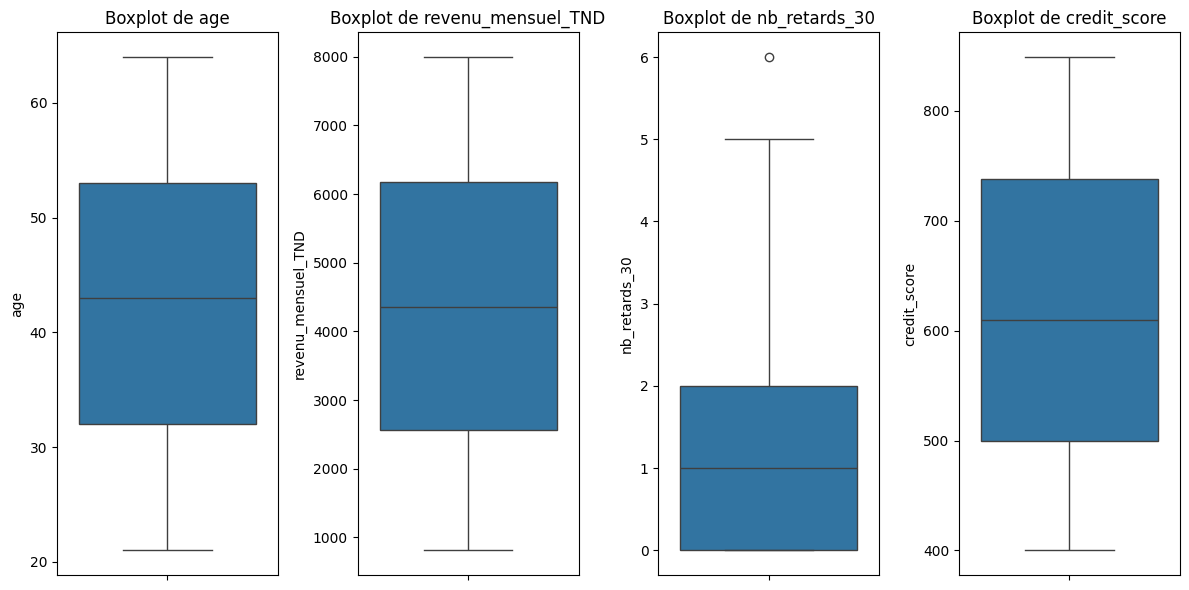

In [102]:
# Boxplots pour outliers sur variables clés
key_num_cols = ['age', 'revenu_mensuel_TND', 'nb_retards_30', 'credit_score']
plt.figure(figsize=(12, 6))
for i, col in enumerate(key_num_cols, 1):
    plt.subplot(1, len(key_num_cols), i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

### Résumé :
* Numériques :
  * Âge moyen ~45 ans (min 18, max 70, skew ~0 = normale, dispersion modérée, std ~10-15)
  * Revenus moyens ~3000 TND (dispersion élevée, skew positive indiquant inégalités).
  * Retards skewés (beaucoup de zéros) , (outliers = clients risqués).
  * Kurtosis élevée indiquant outliers à traiter en Phase 2.
* Catégorielles :
  * Professions ('Cadre' dominant 30%)
  * Secteurs ('Services' top)
  * Cible default_flag déséquilibrée (76% non-défaut vs 24% défaut – à gérer via oversampling).
* Insights :
  * Skew retards indique focus minorité mauvais payeurs pour CIL.
* Prochain :
  * Utiliser ces stats pour feature engineering (ex. : bins pour âge/revenu).

.

### 4. Analyse Univariée

#### Objectif
Examiner distributions individuelles pour détecter formes, outliers, déséquilibres .

visualisations

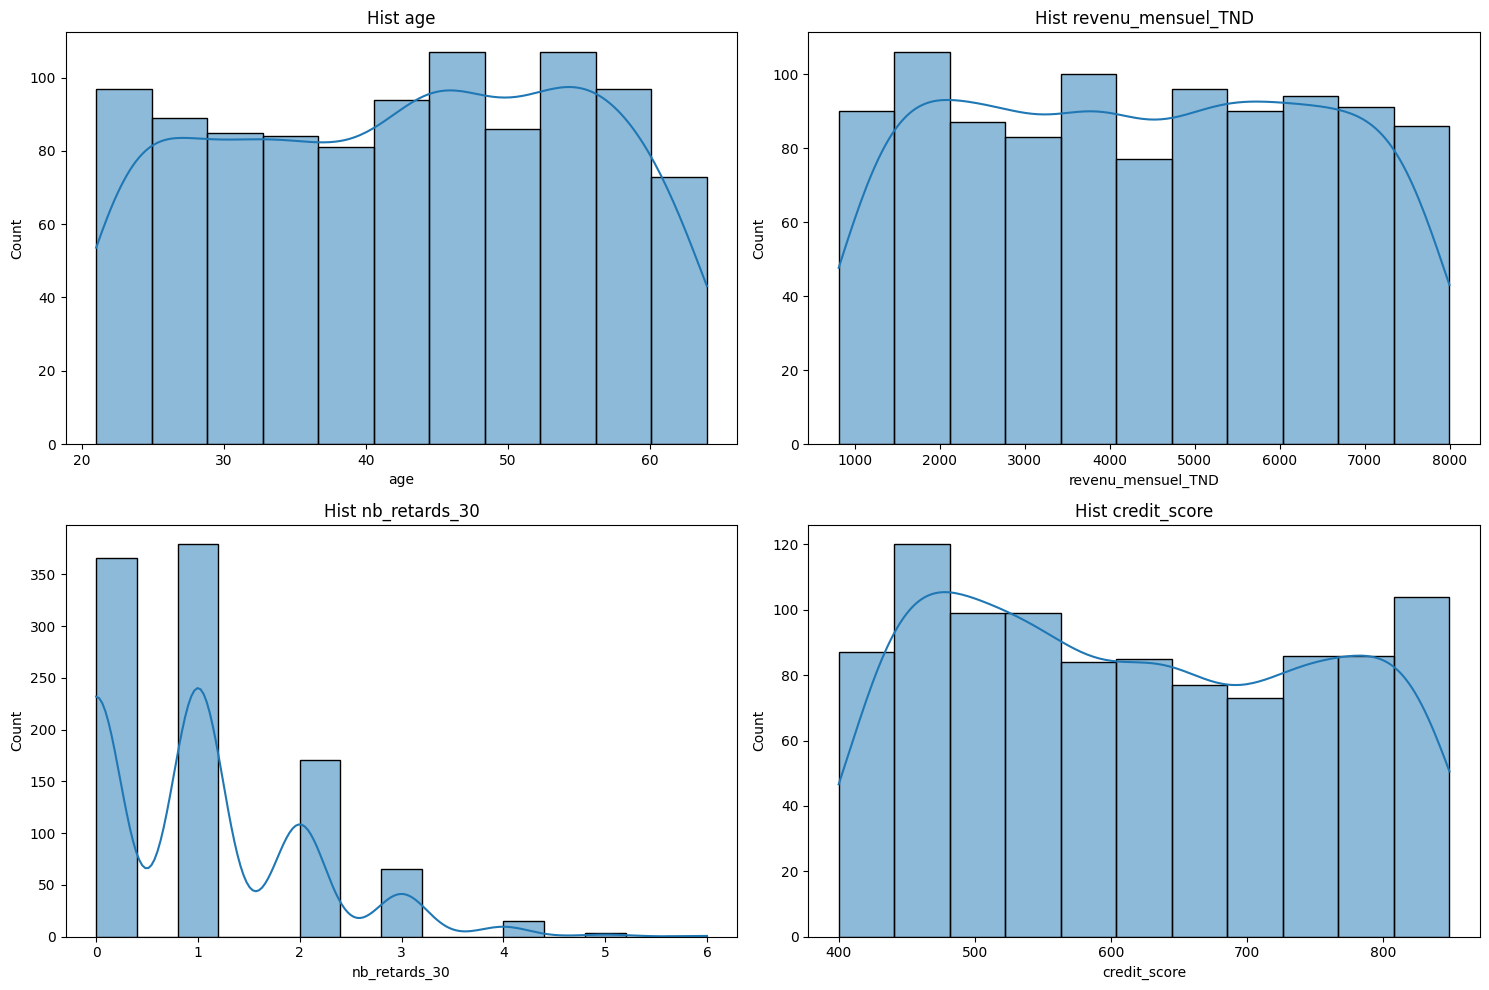

In [109]:
# Histogrammes pour num_cols
if 'df_clean' in globals():
  top_num_cols = ['age', 'revenu_mensuel_TND', 'nb_retards_30', 'credit_score']
  plt.figure(figsize=(15, 10))
  for i, col in enumerate(top_num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_clean[col], kde=True)
    plt.title(f"Hist {col}")
  plt.tight_layout()
  plt.savefig('hist_num.png')
  plt.show()

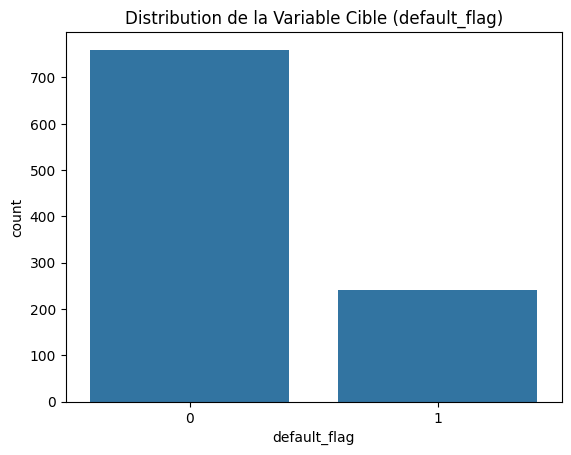

In [112]:
# Countplot pour la distribution du cible
sns.countplot(x='default_flag', data=df_clean)
plt.title("Distribution de la Variable Cible (default_flag)")
plt.savefig('countplot_cible.png')
plt.show()

In [111]:
# Quantification outliers
for col in top_num_cols:
  Q1, Q3 = df_clean[col].quantile([0.25, 0.75])
  outliers = df_clean[(df_clean[col] < Q1 - 1.5*(Q3-Q1)) | (df_clean[col] > Q3 + 1.5*(Q3-Q1))]
  print(f"Outliers {col}: {len(outliers)} ({len(outliers)/len(df_clean):.1%})")

Outliers age: 0 (0.0%)
Outliers revenu_mensuel_TND: 0 (0.0%)
Outliers nb_retards_30: 1 (0.1%)
Outliers credit_score: 0 (0.0%)


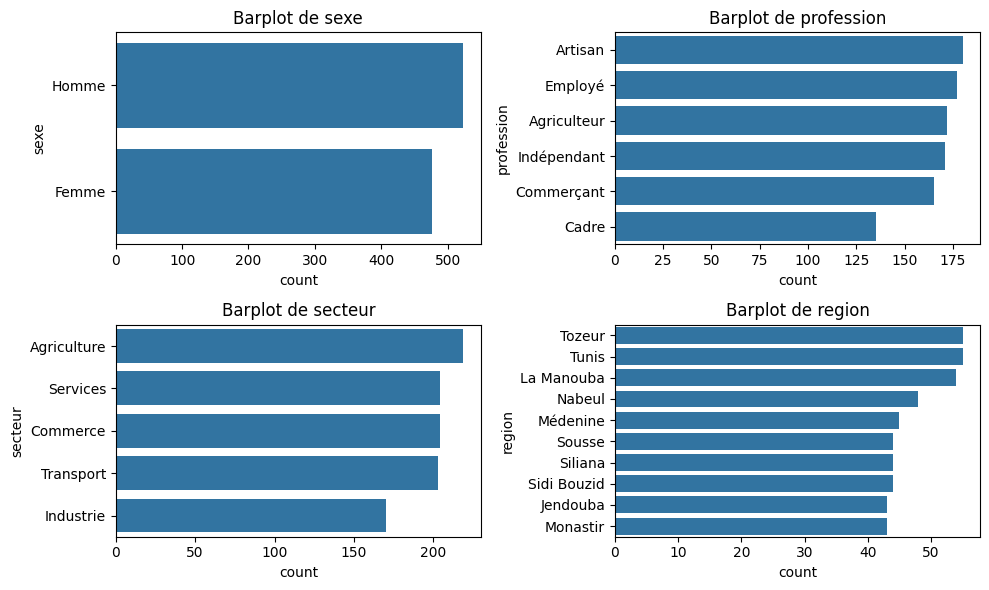

In [113]:
# Barplots pour cat_cols
if 'df_clean' in globals():
  top_cat_cols = ['sexe', 'profession', 'secteur', 'region']
  plt.figure(figsize=(10, 6))
  for i, col in enumerate(top_cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(y=df_clean[col], order=df_clean[col].value_counts().index[:10])  # Top 10 valeurs
    plt.title(f"Barplot de {col}")
plt.tight_layout()
plt.savefig('hist_cat.png')
plt.show()

#### Résumé
- Répartition variables :
  * Numériques souvent normales (âge) ou skewées (retards, revenus – indiquant minorité à haut risque).
  * Catégorielles équilibrées (sexe ~50/50) mais professions concentrées.
- Équilibre cible :
  * Déséquilibrée (majorité non-défaut : 76/24% )
  * Premiers insights : Plus de risques chez jeunes/bas revenus ?
- Hypothèse :
  * Jeunes/indépendants plus risqués ?

.

### 5. Analyse Bivariée


Explorer relations cible-expl et corr num pour identifier drivers risque leasing.

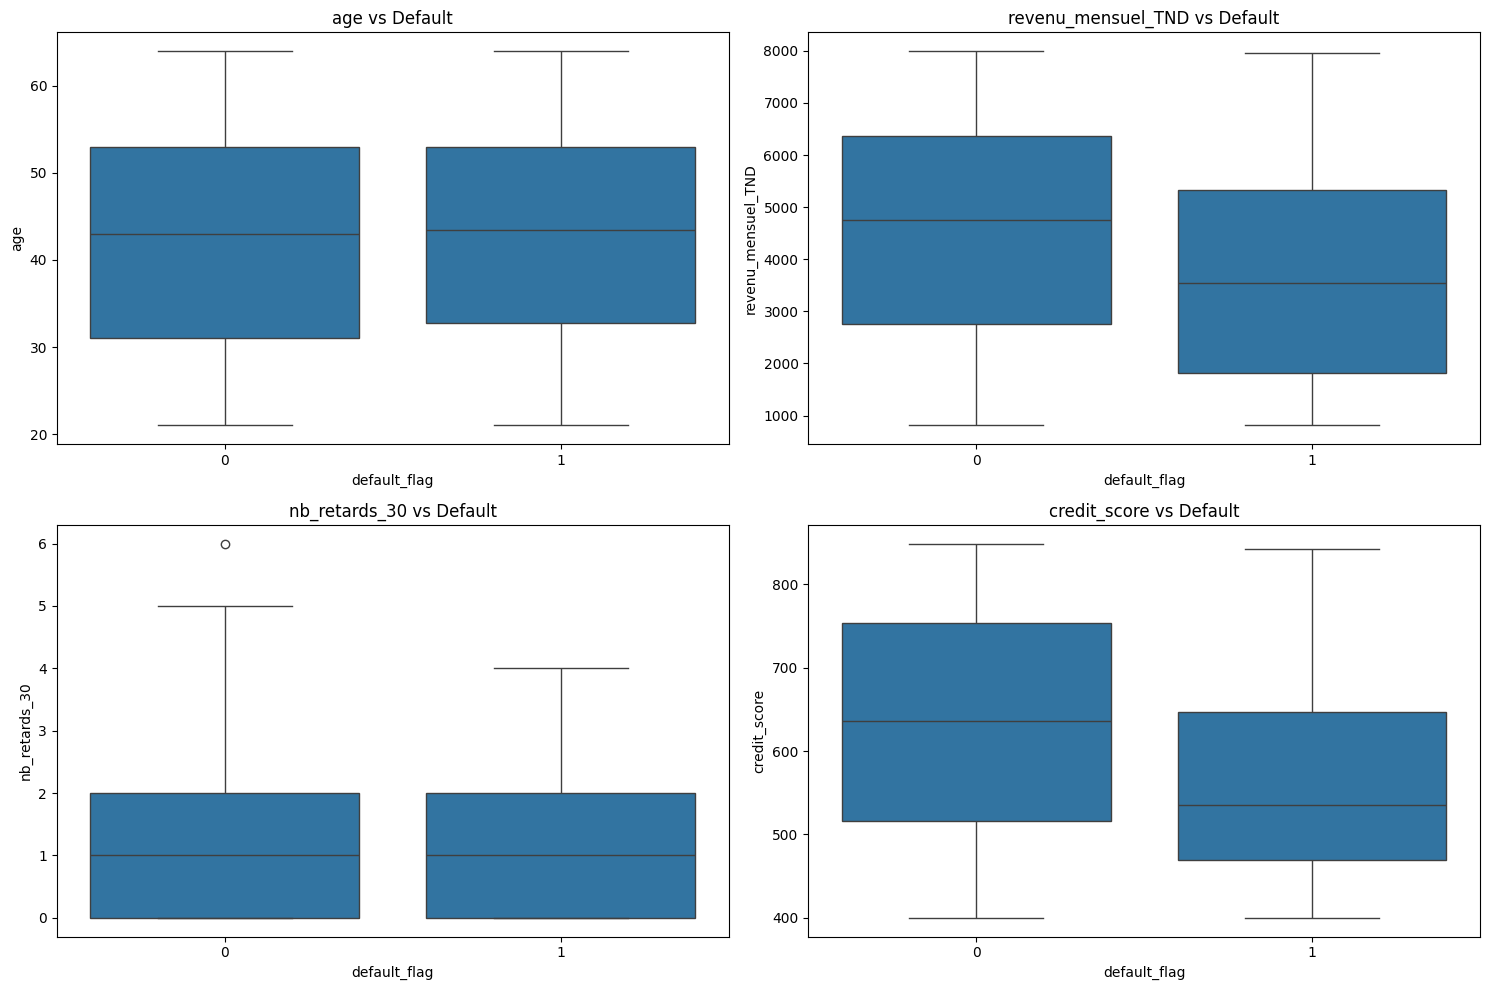

In [115]:
# Boxplots cible vs num clés
if 'df_clean' in globals():
    key_vars = ['age', 'revenu_mensuel_TND', 'nb_retards_30', 'credit_score']
    plt.figure(figsize=(15, 10))
    for i, var in enumerate(key_vars, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(x='default_flag', y=var, data=df_clean)
        plt.title(f"{var} vs Default")
    plt.tight_layout()
    plt.savefig('box_bivarie.png')
    plt.show()

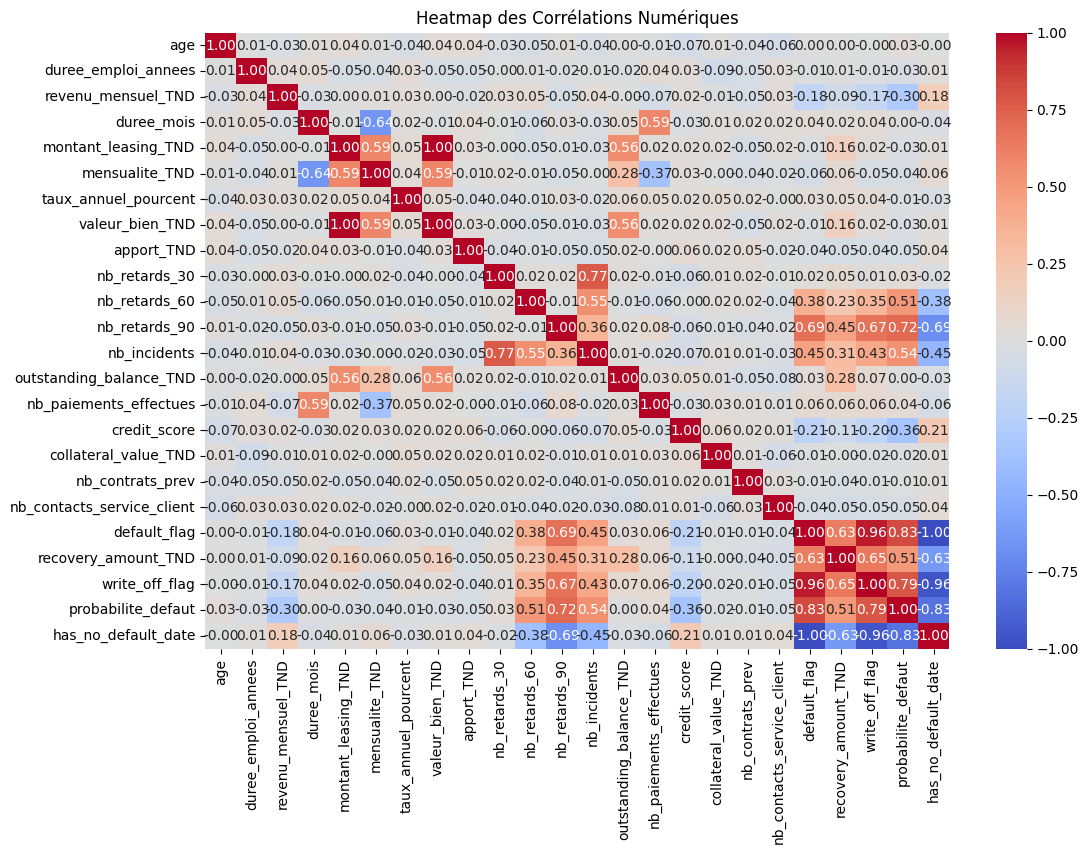

In [118]:
# Heatmap de corrélation num
num_df = df_clean.select_dtypes(include=['int64', 'float64'])
corr_matrix = num_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap des Corrélations Numériques")
plt.savefig('heatmap_corr.png')
plt.show()

On va évaluer la multicolinéarité entre les variables numériques grâce au Variance Inflation Factor (VIF) pour identifier les variables redondantes

In [119]:
# VIF
num_df_noinf = num_df.drop(columns=['default_flag'], errors='ignore').fillna(0)
vif = pd.DataFrame({'Feature': num_df_noinf.columns, 'VIF': [variance_inflation_factor(num_df_noinf.values, i) for i in range(num_df_noinf.shape[1])]})
print("VIF :", vif.sort_values('VIF', ascending=False))

VIF :                        Feature          VIF
12                nb_incidents          inf
9                nb_retards_30          inf
10               nb_retards_60          inf
11               nb_retards_90          inf
7              valeur_bien_TND  5290.775336
4          montant_leasing_TND  5024.419361
22         has_no_default_date    45.590759
15                credit_score    34.335737
21          probabilite_defaut    30.627444
6         taux_annuel_pourcent    18.083980
3                   duree_mois    17.013278
20              write_off_flag    14.346512
0                          age    12.333670
5               mensualite_TND    10.019932
2           revenu_mensuel_TND     9.514397
16        collateral_value_TND     4.104960
8                   apport_TND     4.006145
1          duree_emploi_annees     3.939461
14      nb_paiements_effectues     3.937470
18  nb_contacts_service_client     3.768972
13     outstanding_balance_TND     3.372020
17            nb_contrats_

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



interprétation du VIF

| Valeur VIF   | Interprétation                                    |
| ------------ | ------------------------------------------------- |
| \~1          | Pas de corrélation multicolinéaire                |
| Entre 1 et 5 | Corrélation modérée, généralement acceptable      |
| > 5 ou 10    | Forte multicolinéarité, problématique potentielle |


Taux défaut par profession :


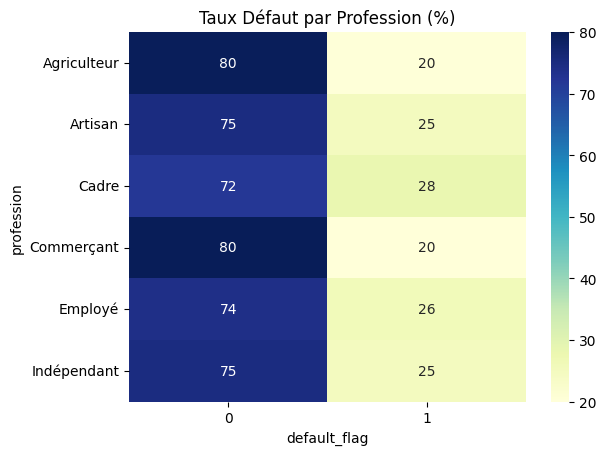

In [121]:
# Crosstab
print("Taux défaut par profession :")
crosstab = pd.crosstab(df_clean['profession'], df_clean['default_flag'], normalize='index') * 100
sns.heatmap(crosstab, annot=True, cmap='YlGnBu')
plt.title("Taux Défaut par Profession (%)")
plt.savefig('crosstab_profession.png')
plt.show()

#### Résumé
- Relations cible-expl :
  * Défauts ont crédit bas (moy ~400 vs 600 non-défaut)
  * Retards hauts
  * –> confirme historique paiement clé pour CIL.
- Variables influentes :
  * Fortes corr :
    * positives retards/default (ex. : nb_retards_90 >0.5).
    * négatives crédit/revenu/default.
- Corrélations importantes :
  * Retards corrélés entre eux (>0.7 – multicolinéarité à surveiller).

.

### 6. Visualisations Avancées

#### Objectif
Visuals complexes pour patterns cachés (ex. : séparation classes via KDE).

Pour patterns plus fins.

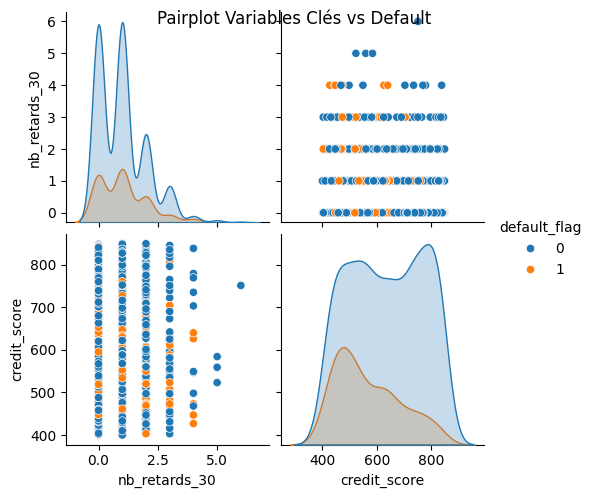

In [124]:
# Pairplot sur vars clés
if 'df_clean' in globals():
    key_vars = ['nb_retards_30', 'credit_score', 'default_flag']
    sns.pairplot(df_clean[key_vars], hue='default_flag', diag_kind='kde')
    plt.suptitle("Pairplot Variables Clés vs Default")
    plt.savefig('pairplot.png')
    plt.show()

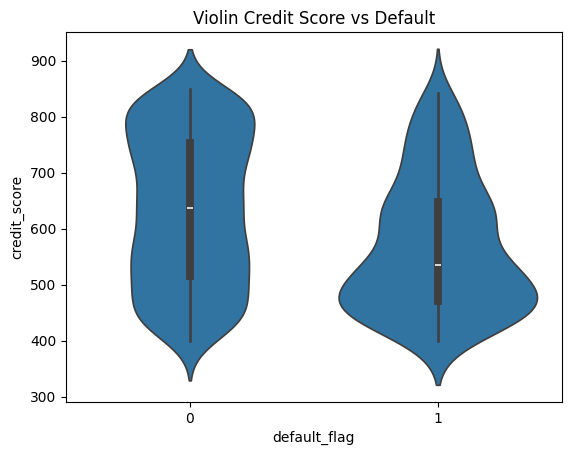

In [127]:
# Visualisation de la distribution de la variable credit_score selon la classe default_flag avec Violinplot
if 'df_clean' in globals():
    key_vars = ['nb_retards_30', 'credit_score', 'default_flag']
    sns.violinplot(x='default_flag', y='credit_score', data=df_clean)
    plt.title("Violin Credit Score vs Default")
    plt.savefig('violin_credit.png')
    plt.show()

#### Résumé
- Séparation nette retards/crédit
- Seuil crédit <400 = risque

.

### 7. Préparation pour la Phase 2

Plan de nettoyage et engineering.

In [134]:
# Identification des colonnes catégorielles pour encodage futur
if 'df_clean' in globals():
    cat_cols = df_clean.select_dtypes('object').columns
    cat_to_onehot = [col for col in cat_cols if df_clean[col].nunique() < 10]
    cat_to_label = [col for col in cat_cols if df_clean[col].nunique() >= 10]
    print("OneHot :", cat_to_onehot)
    print("Label :", cat_to_label)

OneHot : ['sexe', 'profession', 'secteur', 'type_bien', 'collateral_type', 'motifs_contacts', 'branch_id', 'channel']
Label : ['client_id', 'region', 'contract_id']


In [135]:
if 'df_clean' in globals():
  cols_to_drop = ['branch_id']
  print("Cols à drop :", cols_to_drop)

Cols à drop : ['branch_id']


In [136]:
if 'df_clean' in globals():
  print("Manquants restants :", df_clean.isna().sum()[df_clean.isna().sum() > 0])
  print("Équilibre classes (%):", df_clean['default_flag'].value_counts(normalize=True) * 100)

Manquants restants : Series([], dtype: int64)
Équilibre classes (%): default_flag
0    76.0
1    24.0
Name: proportion, dtype: float64


In [137]:
corr_target = corr_matrix['default_flag'].abs().sort_values(ascending=False).index[1:11]
print("Features importantes :", list(corr_target))

Features importantes : ['default_flag', 'write_off_flag', 'probabilite_defaut', 'nb_retards_90', 'recovery_amount_TND', 'nb_incidents', 'nb_retards_60', 'credit_score', 'revenu_mensuel_TND', 'mensualite_TND']


In [138]:
# Feature initiale
df_clean['ratio_mensualite_revenu'] = df_clean['mensualite_TND'] / df_clean['revenu_mensuel_TND']
print("Nouvelle feature :", df_clean['ratio_mensualite_revenu'].describe())

Nouvelle feature : count    1000.000000
mean        0.985288
std         1.228925
min         0.030058
25%         0.302185
50%         0.609493
75%         1.175243
max        12.021824
Name: ratio_mensualite_revenu, dtype: float64


#### Résumé Final Phase 1
- Exploré :
  * 1000x38
  * Vars clés retards/crédit

- Problèmes :
  * Déséquilibre (SMOTE)
  * Outliers retards
  * Multicol (VIF)

- Hypothèses :
  * Bas crédit/hauts retards = défaut

- Préparation :
  * Encode (OneHot/Label)
  * Drop IDs
  * Feature ratio
  * Exporté `clean_data_phase1.csv`.

### Phase 2 – Préparation & Analyse Exploratoire

.

🎯 Objectif : Nettoyer et comprendre les données.

Nettoyage

Gestion des valeurs manquantes

Encodage des variables catégorielles (OneHot, Label Encoding)

Détection et traitement des outliers

Analyse exploratoire (EDA)

Visualisation : distribution des variables, corrélations (Seaborn, Matplotlib)

Analyse des profils bons vs mauvais payeurs

Création de nouvelles variables (taux d’endettement, mensualité/revenu, etc.)

📌 Livrable fin de phase : Rapport EDA avec graphiques + premières hypothèses.

### Phase 3 – Modélisation Machine Learning

In [ ]:
🎯 Objectif : Construire un modèle performant.

Séparation train/test

Modèles ML classiques : Logistic Regression, Random Forest, XGBoost

Évaluation : Accuracy, Precision, Recall, F1, ROC-AUC

Optimisation : GridSearchCV ou RandomSearchCV

Interprétation : SHAP values ou Feature Importance

📌 Livrable fin de phase : Notebook ML + tableau comparatif des modèles.

### Phase 4 – Deep Learning / IA

In [ ]:
🎯 Objectif : Apporter une touche IA/Deep Learning.

Construire un petit réseau de neurones (Keras/TensorFlow ou PyTorch) pour prédire le risque

Comparer avec les modèles ML classiques

Si temps disponible : intégrer un modèle Explainable AI (LIME, SHAP) pour justifier les prédictions

📌 Livrable fin de phase : Notebook Deep Learning + comparaison finale.

### Phase 5 – Plateforme intelligente

In [ ]:
🎯 Objectif : Rendre le modèle utilisable par l’entreprise.

Développer un mini-dashboard ou une app web avec :

Streamlit (facile et rapide) ou Flask/Django (plus flexible)

Input des données client → sortie : probabilité de défaut + recommandations

Option bonus : connexion à Power BI pour dashboard interactif.

📌 Livrable fin de phase : Application déployée localement ou en ligne (Heroku, Streamlit Cloud).

### Phase 6 – Soutenance & Rapport

In [ ]:
🎯 Objectif : Finaliser la documentation et la présentation.

Présentation PowerPoint (structure) :

Introduction & contexte métier

Données utilisées

Approche technique

Résultats & interprétation

Démo plateforme

Conclusion & perspectives

Rapport de stage :

Introduction & objectifs

État de l’art / contexte métier

Méthodologie

Résultats

Discussion & limites

Conclusion & recommandations

📌 Livrables finaux : PPT + rapport PDF + code/documentation.

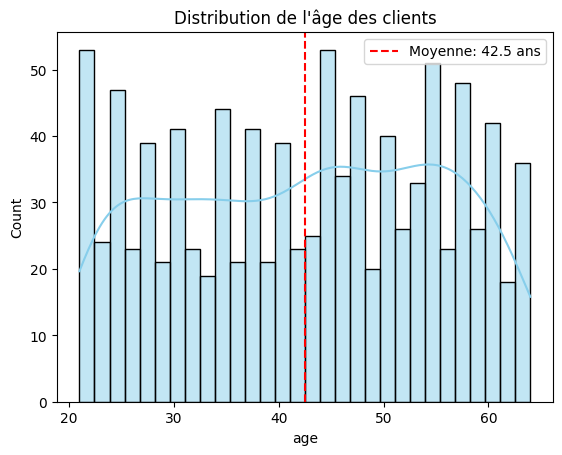

In [ ]:
#histogramme de l'âge avec ligne de moyenne
if 'age' in df.columns:
    plt.figure()
    sns.histplot(df['age'], bins=30, kde=True, color='skyblue')
    plt.axvline(df['age'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["age"].mean():.1f} ans')
    plt.title('Distribution de l\'âge des clients')
    plt.legend()
    plt.show()

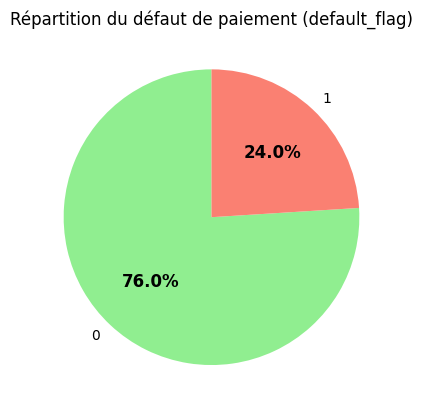


🔴 Taux global de défaut: 24.00%


In [ ]:
#répartition du default_flag (cible)
if 'default_flag' in df.columns:
    target_dist = df['default_flag'].value_counts(normalize=True)
    plt.figure()
    patches, texts, autotexts = plt.pie(target_dist,
                                       labels=target_dist.index,
                                       colors=['lightgreen', 'salmon'],
                                       autopct='%1.1f%%',
                                       startangle=90)
    plt.setp(autotexts, size=12, weight="bold")
    rotation=45
    plt.title('Répartition du défaut de paiement (default_flag)')
    plt.show()

    # Taux global de défaut
    default_rate = df['default_flag'].mean() * 100
    print(f"\n🔴 Taux global de défaut: {default_rate:.2f}%")

Pour cat : Value_counts et nunique : Montre top catégories et cardinalité (ex. : professions dominantes).

In [ ]:
# Pour catégorielles : nunique et top values
#cat_df = df.select_dtypes(include=['object'])
#for col in cat_df.columns:
    #print(f"\n{col} - Nombre de valeurs uniques: {df[col].nunique()}")
    #print("Top 5 valeurs:")
    #print(df[col].value_counts().head())

In [ ]:
#comptage des catégories pour les variables catégorielles
#cat_cols = df.select_dtypes(include=['object', 'category']).columns
#for col in cat_cols:
    #print(f"\nDistribution de {col}:")
    #print(df[col].value_counts(normalize=True).round(2))

### Analyse et traitement des valeurs manquantes

In [ ]:
# 1. Identification précise des colonnes problématiques
cols_manquantes = df.isna().mean()[df.isna().mean() > 0].sort_values(ascending=False)
print("Colonnes avec valeurs manquantes et leurs pourcentages:")
print(cols_manquantes.apply(lambda x: f"{x:.1%}"))


In [ ]:
# 2. Analyse des colonnes spécifiques
col_76 = cols_manquantes.index[0]  # Colonne avec 76% de NaN
col_18 = cols_manquantes.index[1]   # Colonne avec 18.5% de NaN

print(f"\nStatistiques pour la colonne '{col_76}':")
print(df[col_76].describe())
print(f"\nValeurs uniques pour '{col_76}':")
print(df[col_76].dropna().unique()[:10])  # Affiche les 10 premières valeurs uniques

print(f"\nStatistiques pour la colonne '{col_18}':")
print(df[col_18].describe())


In [ ]:
# Barplot pour visualiser les pourcentages manquants
plt.figure(figsize=(10, 6))
sns.barplot(x=cols_manquantes.index, y=cols_manquantes.values * 100)
plt.ylabel("Pourcentage (%)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 3. Stratégies de traitement différentes selon le pourcentage

# Pour la colonne avec 76% de NaN (trop élevé pour imputer)
print(f"\nTraitement recommandé pour '{col_76}' (76% manquants):")
print("- Suppression probable de la colonne (trop de données manquantes)")
print("- Alternative: Créer un indicateur binaire 'has_{col_76}' si l'information absente est significative")

# Pour la colonne avec 18.5% de NaN
print(f"\nTraitement recommandé pour '{col_18}' (18.5% manquants):")
print("- Imputation par la médiane/moyenne si numérique")
print("- Imputation par le mode si catégorielle")
print("- Imputation avec 'Inconnu' ou une valeur spéciale")
print("- Modélisation des valeurs manquantes si le pattern est important")

In [ ]:
# 4. Exemples de mise en œuvre
# Option 1: Suppression de la colonne à 76%
df_clean = df.drop(columns=[col_76])

# Option 2: Imputation pour la colonne à 18.5%
if df[col_18].dtype == 'object':
    # Pour une variable catégorielle
    df_clean[col_18] = df[col_18].fillna('Inconnu')
else:
    # Pour une variable numérique
    median_val = df[col_18].median()
    df_clean[col_18] = df[col_18].fillna(median_val)
    print(f"\nValeur médiane utilisée pour l'imputation: {median_val}")

In [ ]:
# 5. Vérification du résultat
print("\nVérification après traitement:")
print(df_clean.isna().sum())